✅ Epoch 1/100 hoàn thành
✅ Epoch 2/100 hoàn thành
✅ Epoch 3/100 hoàn thành
✅ Epoch 4/100 hoàn thành
✅ Epoch 5/100 hoàn thành
✅ Epoch 6/100 hoàn thành
✅ Epoch 7/100 hoàn thành
✅ Epoch 8/100 hoàn thành
✅ Epoch 9/100 hoàn thành
✅ Epoch 10/100 hoàn thành
✅ Epoch 11/100 hoàn thành
✅ Epoch 12/100 hoàn thành
✅ Epoch 13/100 hoàn thành
✅ Epoch 14/100 hoàn thành
✅ Epoch 15/100 hoàn thành
✅ Epoch 16/100 hoàn thành
✅ Epoch 17/100 hoàn thành
✅ Epoch 18/100 hoàn thành
✅ Epoch 19/100 hoàn thành
✅ Epoch 20/100 hoàn thành
✅ Epoch 21/100 hoàn thành
✅ Epoch 22/100 hoàn thành
✅ Epoch 23/100 hoàn thành
✅ Epoch 24/100 hoàn thành
✅ Epoch 25/100 hoàn thành
✅ Epoch 26/100 hoàn thành
✅ Epoch 27/100 hoàn thành
✅ Epoch 28/100 hoàn thành
✅ Epoch 29/100 hoàn thành
✅ Epoch 30/100 hoàn thành
✅ Epoch 31/100 hoàn thành
✅ Epoch 32/100 hoàn thành
✅ Epoch 33/100 hoàn thành
✅ Epoch 34/100 hoàn thành
✅ Epoch 35/100 hoàn thành
✅ Epoch 36/100 hoàn thành
✅ Epoch 37/100 hoàn thành
✅ Epoch 38/100 hoàn thành
✅ Epoch 39/100 hoàn t

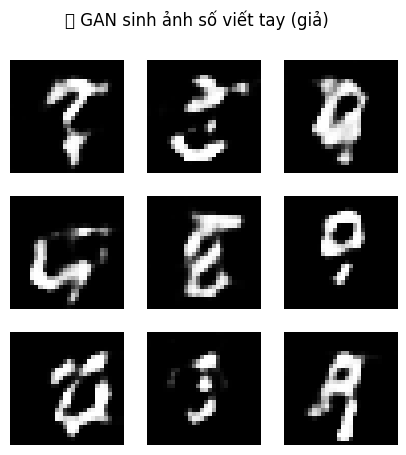

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Tải dữ liệu MNIST (ảnh 28x28 trắng đen)
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train - 127.5) / 127.5   # chuẩn hóa [-1,1]
X_train = np.expand_dims(X_train, axis=-1)
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 2️⃣ Tạo dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3️⃣ Xây Generator (tạo ảnh giả)
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*128, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7,7,128)),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# 4️⃣ Xây Discriminator (phân biệt thật/giả)
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

G = make_generator()
D = make_discriminator()

# 5️⃣ Hàm mất mát và tối ưu
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def gen_loss(fake_output): return cross_entropy(tf.ones_like(fake_output), fake_output)
def disc_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

# 6️⃣ Huấn luyện vài epoch đơn giản
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([16, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake = G(noise, training=True)
        real_output = D(images, training=True)
        fake_output = D(fake, training=True)
        g_loss = gen_loss(fake_output)
        d_loss = disc_loss(real_output, fake_output)
    grads_g = gen_tape.gradient(g_loss, G.trainable_variables)
    grads_d = disc_tape.gradient(d_loss, D.trainable_variables)
    gen_opt.apply_gradients(zip(grads_g, G.trainable_variables))
    disc_opt.apply_gradients(zip(grads_d, D.trainable_variables))

for epoch in range(EPOCHS):
    for batch in dataset.take(100):  # chỉ huấn luyện nhẹ cho nhanh
        train_step(batch)
    print(f"✅ Epoch {epoch+1}/{EPOCHS} hoàn thành")

# 7️⃣ Sinh ảnh mới từ noise
noise = tf.random.normal([9, 100])
gen_imgs = G(noise, training=False)
gen_imgs = (gen_imgs + 1) / 2.0

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("🧠 GAN sinh ảnh số viết tay (giả)")
plt.show()
